# Learning to Learn

In [2]:
import plots, processing
import numpy as np

## Abstract

Neural networks are very popular nowadays, with a lot of libraries offering very efficient way of using them. Many problems are solvable using a neural network, but finding the right one, the more efficient, the more accurate is very complex and time consuming. Finding the optimal parameters of a neural network can be difficult. People are used to optimizing them by hand, using their knowledge on neural networks. The effort required to find an optimal or quasi optimal configuration is so high that people usually use non-optmized netwoks. In this report i compare a few solutions proposed to optimize these parameters. i've applyed the solutions on the dataset MNIST [[6](#6)].

![alt text](https://cdn-images-1.medium.com/max/800/1*iBXYuc9YNDGf7GU4PzkWDQ.png)

The steps of this lesson
1. [The problem to optimize](#1.-The-problem-to-optimize) where we describe the what is the learning problem and its hyperparameters,
2. [Random search](#2.-hyperRand:-Random-search) where we explore a basic random search for reference,
3. [NN designing NN](#3.-hyperLearn:-NN-desning-NN) where we implement a neural network to predict the set of hyperparameters to use [[9](#9)],
4. [MADS algorithm](#4.-hyperMads:-MADS-algorithm) where we apply the MADS algorithm [[7](#7)] for blackbox optimization to the problem using OPAL [[8](#8)],
5. [Bayesian optimization](#5.-hyperBayes:-Bayesian-optimization) where apply bayesian optimization [[10](#10)] to the training,
6. [Comparison & Joint appoarch](#6.-Comparison-&-joint-appoarch) where we propose mixed approches to tke advantage of the strengh of all the different algorithms.

Last, we list the references and tools used for this project in [Reference and acknowledgements](#Reference-and-acknowledgements)

## 1. The problem to optimize

### The Dataset

![alt text](https://kuanhoong.files.wordpress.com/2016/01/mnistdigits.gif)


For this project i used the well known dataset MNIST [[6](#6)]. The dataset is composed by 80 000 classified images reprensenting the numbers from 0 to 9. 
The training set is composed of 60 000 images, the test set and the validation set 10 000. We do not use any augmentation.

### The Model

We choose to implement the model using Keras [[3](#3)]. We used both tensorflow [[2](#2)] and Theano [[1](#1)] as the underlying layer.<br>
The basic model is a logistic regression with 784 inputs and 10 outputs using as loss the categorical crossentropy and as optimizer a SGD. 
We choose to fix the __number of epochs to 100__ and the __batch size to 200__. This choice was made to simplify the problem and to impose the network to find a solution in a reasonable time.<br>

All remaning parameters are used for the optimisation.<br>

One MNIST training took 1-2 minutes on our computers.<br>

### Choice of hyperparameters

We choose for this project to optimise the network on the following parameters with a stochastic gradient descent optimisation:
- The __number of layers__ : from 0 to 3
- The __number of neurons per layer__ : from 0 to 500
- The __learning rate__ : from 0 to 1
- The __L1 regularisation__ coefficient : from 0 to 1
- The __L2 regularisation__ coefficient : from 0 to 1
- The __momentum__ (wheight of previous gradient in SGD): from 0 to 1
- The __decay__ for the learning rate : from 0 to 1
- The __nesterov__ method for calculating momentums : true or false
- The __activation__ function of all hidden layers : tanh, sigmoid or relu

The number of layers and neurons is a strict policy as it controls the capacity of the model. However, for the other ranges, this is more of a general guideline. There are here to guide the algorithm toward "relevant values". When an algorithm would not behave well close to zero or with too large values, we would ajust them a little.
This is a tradeoff between the maximum accuracy possible and the convergence of the algorithm.

### Comparing models

The measure for one set of hyperparameters is the __validation accuracy__ after the training of the full training set (100 epochs).

For a pure theorical approch, we would need to run the an algorithm on a fixed number of training on MNIST (e.g. 200) multiple times to account for the probabilistic perspective of the algorithm.
We would also need to repeat this operation on a number of problem different than MNIST. We clearly do not have this kind of computing power.

Running a specific algorithm also need to adjust a couple of parameters (hopefully less than training MNIST), or even small redefinitions of the problem as stated previously. This kind of intervention is hard to account for on a theorical level.

Therefore, we will compare the different algorithms from the perspective of an individual trying to optimize the training of his neural network. The individual can make some obvious adjustments but expects the optimisation algorithm to do the heavy lifting.

## 2. hyperRand: Random search

The most natural idea after bruteforce is to explore a random search. Any solution comparing worse to this solution cannot be retained as a good solution.
We used the following marginal probabilty distribution to sample for our experiments:
- The __number of layers__ is __fixed__ to 2
- The __number of neurons per layer__ is sampled from a __poisson__ distribution of parameter 200
- The __learning rate__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __L1 regularisation__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __L2 regularisation__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __momentum__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __decay__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __nesterov__ is sample from a __uniform__ distribution
- The __activation__ is sample from a __uniform__ distribution

The number of layer has been fixed to 2 layers to compare better with [hyperMads](#4.-hyperMads:-MADS-algorithm) and hyper that we didn't have time to run on more than three layers [hyperBayes](#5.-hyperBayes:-Bayesian-optimisation). The conclusion would not change thought.

A Poisson distribution is a tool that helps to predict the probability of certain events from happening when you know how often the event has occurred. The Poisson distribution gives us the probability of a given number of events happening in a fixed interval of time.
![alt text](http://www.statisticshowto.com/wp-content/uploads/2013/10/poisson-distribution.png)

a log-normal (or lognormal) distribution is a continuous probability distribution of a random variable whose logarithm is normally distributed (a function that represents the distribution of many random variables as a symmetrical bell-shaped graph.)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/300px-PDF-log_normal_distributions.svg.png)


A uniform distribution, sometimes also known as a rectangular distribution, is a distribution that has constant probability.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/1280px-Uniform_Distribution_PDF_SVG.svg.png)




Best accuracy: 0.9173 at iteration 4
Number of solutions better than 80%: 5.0%


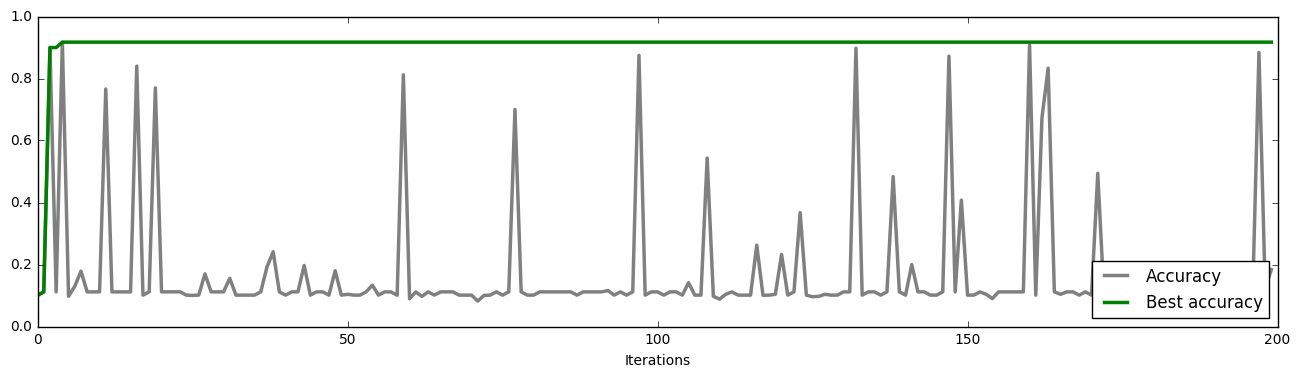

In [2]:
accRand = processing.accuracy("results/hyperRand.json")
plots.summary(accRand, .8)
plots.accuracy(accRand)

With only ten solutions better than 80%, and a maximum accuracy of 91.73%, the random search is a __bad algorithm__ for finding good optimal solutions.
One could arguee that the solutions found could be used to initialize another algorithm but all other algorithm already have their own way of generating and exploiting randomness.

In a way, the results really depends on the probabilistic distributions given for the parameters. An extreme case would be the a distribution with little to no variance around an optimal solution. This distribution would perform well but require a dramatic amount of knowledge from the indivual running the algorithm.

The strengths of this algorithm is that it's easy to set up and easy to parallelize (no synchronizing steps).

## 3. hyperLearn: Neural Networks designing Neural networks

For this approach we've re-implemented the solution proposed by [[9](#9)].

### Approach : 

The idea of NN designing NN is to learn a neural network that tries to predict the performance of a Network givens its parameters. The complicated point of this approach is to generate some points on which the neural network can learn, then to refine the neural network on interessant zones to find the optimal solution. The sampling of training points is essential.

### The algorithm

Sample some random hyperparameters and train MNIST on them
train the neural network (RSM)
```python
a = 1e-4
while (n_iteration < max_iter):
    sample a random parameter
    predict its performance p
    if (p> max_performance):
        with probability (1-a):
            train_MNIST
            add result in RSM training set
            train the RSM
            update max_performance if necessary
        else do nothing
    else :
        with probability a
            train_MNIST
            add result in RSM training set
            train the RSM
            update max_performance if necessary
        else do nothing
return the best configuration
```

### The sampling

The previous algorithm is very dependant on sampling hyperparameters to test. The sampling method is a variation of Metropolis–Hastings algorithm. The first sample are random, the following are sampled with a gaussian distribution around the previous one. This method enable a local search around the optimal solution found, but also allows the exploration of the rest of the search space. 

We've beginned using when possible continous hyperparameters values. But this approach was stuck is a local minima and was not able to explore the entire space to find a good solution. This bad result is understandable because of the meaning of the values : a learning rate of 0.1 is very similar to a leaning rate of 0.13, but a learning rate of 0.001 is quite different of a learning rate of 0.031. The gaussian distribution doesn't make any difference between these two examples. Then we followed what was done in the article and we discretized the search space. This way we were able to counter the previous problem, but we've lost in the precision of the optained solution. <br>
Here are the possible values of the parameters : 

```python
values = np.array([
    [0, 1, 2, 3],  #n_couches
    range(10, 500, 10), range(10, 500, 10), range(10, 500, 10),  #couches
    [0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #learning rate
    [0.000001,0.00001,0.0001,0.001,0.01,0.1],  #reg_l1
    [0.000001,0.00001,0.0001,0.001,0.01,0.1],  #reg_l2
    [0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #moment
    [.0,0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #decay
    [0,1],  #nesterov
    [0, 1, 2]  #activation
])
```

### Results

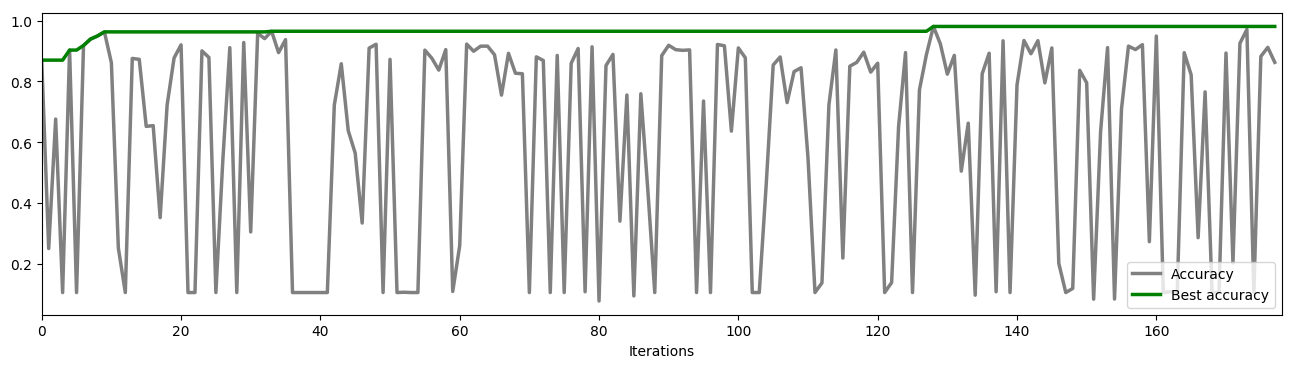

Best accuracy: 0.9806 at iteration 128
Number of solutions better than 90%: 24.7%


In [4]:
accNN = np.load('../hyperLearn/hist_res.npy')
plots.accuracy(accNN)
plots.summary(accNN,.9)

The RSM algorithm find quickly a good result (96% at iteration 9) and the final result is comparable to the ones of the other algorithms. <br>
The algorithm manage to search most of the time in interesting areas, mostly at the beginnig. Once he founds a good solution it begins to search for other good solutions in the search space.
This algorithm is limited by the discretization of the search space.

## 4. hyperMads: MADS algorithm

The MADS algorithm [[7](#7)] stands for _Mesh Adaptive Direct Search_. It's an algorithm designed for black box optimization, that is to say an algorithm to look for the minimum of a function on which we have little information.
The function is hard to compute (can be days), may not be smooth, and may even fail to compute. The algorithm use an adaptive mesh to search the solution space.

In the adaptive mesh refinement technique we start with a base coarse grid. As the solution proceeds we identify the regions requiring more resolution by some parameter characterizing the solution, say the local truncation error. We superimpose finer subgrids only on these regions. Finer and finer subgrids are added recursively until either a given maximum level of refinement is reached or the local truncation error has dropped below the desired level. Thus in an adaptive mesh refinement computation grid spacing is fixed for the base grid only and is determined locally for the subgrids according to the requirements of the problem.


* We did not manage to use the categorical variables, although supported by the software, and decided to set
    ```python
        {"activation": "relu",
         "nesterov":   True}
    ```
* The other parameters needed a default value, we gave arbirarily the values
    ```python
        {"learnnig_rate": 1e-3,
         "reg_l1":        1e-4,
         "reg_l2":        1e-4,
         "moment":        1e-2,
         "decay":         1e-6,
         "noeuds":        [200, 200, 0]  # neurons
        }
    ```
    Note that the number of neurons on the third hidden layer is zero as we wanted to give a default with two layers (middle between one and three).

Best accuracy: 0.9668 at iteration 181
Number of solutions better than 90%: 74.0%
Accuracy at iteration 9: 0.9629


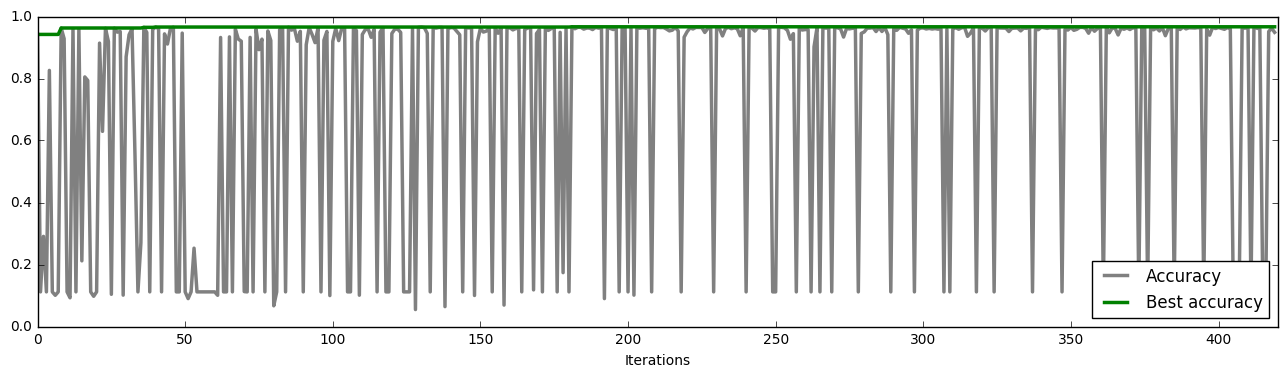

In [4]:
accMads = processing.accuracy("results/hyperMads.json")
plots.summary(accMads, .9)
print("Accuracy at iteration 9: {}".format(accMads[8]))
plots.accuracy(accMads)

The algorithm quickly found a good solution (96.29% at iteration 9), but we can notive that it was lucky on it first guess (94,22% accuracy).

Using MDS on the parameters used for the search (normalized by the size of the search space), we notice two things. First First that all the good solutions were found close to each other. Second that even in this close space, the accuracy is pretty noisy.

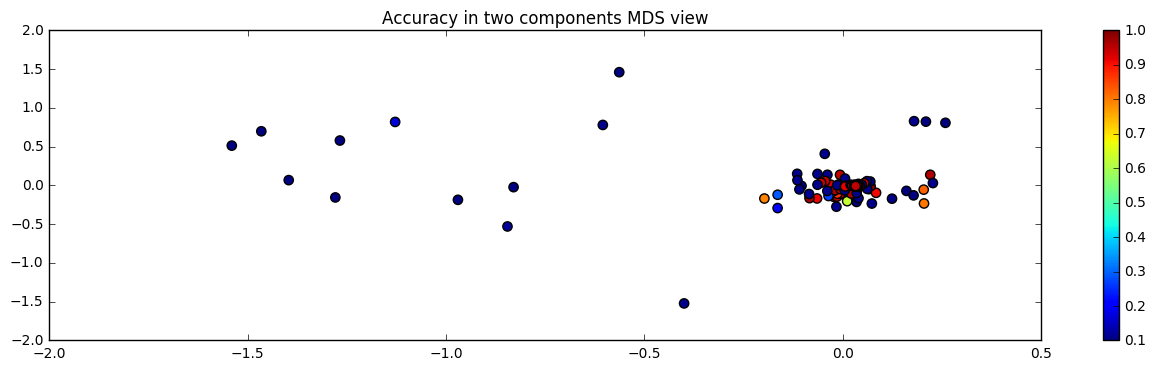

In [5]:
varMads = []
for p in processing.params("results/hyperMads.json"):
    noeuds = p["noeuds"] + [0]*(3 - p["n_couches"])
    varMads.append([p["decay"], p["learning_rate"],
                    p["moment"], p["reg_l1"], p["reg_l2"],
                    noeuds[0], noeuds[1], noeuds[2]])
varMads = np.array(varMads)

plots.mds_accuracy(varMads / [1,1,1,1,1,500, 500, 500], accMads)

The function to optimize has a difficult structure to study and MADS fails to find new solutions. 
A good example of this is that only 22 training points have stricltly more than 1 neurons on the third layer.

To improve performance, we could make use of suroggate functions. Namely, a function that behave the same way as the original function but do not necessary approximate it. Such a function could be obptained by reducing the max number of epoch for instance.

## 5. hyperBayes: Bayesian optimization

Bayesian optimization is another type of blackbox optimization for continuous function which models the function with a Gaussian process [[10](#10)]. It's also possible to use neural network to represents those distribution [[11](#11)] but this was not explored here.


Bayesian optimization1 falls in a class of optimization algorithms called sequential model-based optimization (SMBO) algorithms. These algorithms use previous observations of the loss f, to determine the next (optimal) point to sample f for. The algorithm can roughly be outlined as follows.

1. Using previously evaluated points x, compute a posterior expectation of what the loss f looks like.
2. Sample the loss f at a new point xnewxnew, that maximizes some utility of the expectation of f. The utility specifies which regions of the domain of f are optimal to sample from.
These steps are repeated until some convergence criterion is met.




After a couple of failed attempts (or at least slow start), we decided to restrict a little the hyperparameters possbible values to: 
* the learning rate between `1e-4` and`.5`,
* the L1 regularization coefficient was set between `1e-6` and `.1`,
* the L2 regularization coefficient, the moment and the decay were set between `1e-4` and `.1`,
* the number of neurson was set to two layers between 200 and 300 neurons

With this configuration, we got very good solutions:

Best accuracy: 0.9794 at iteration 161
Number of solutions better than 90%: 69.3%


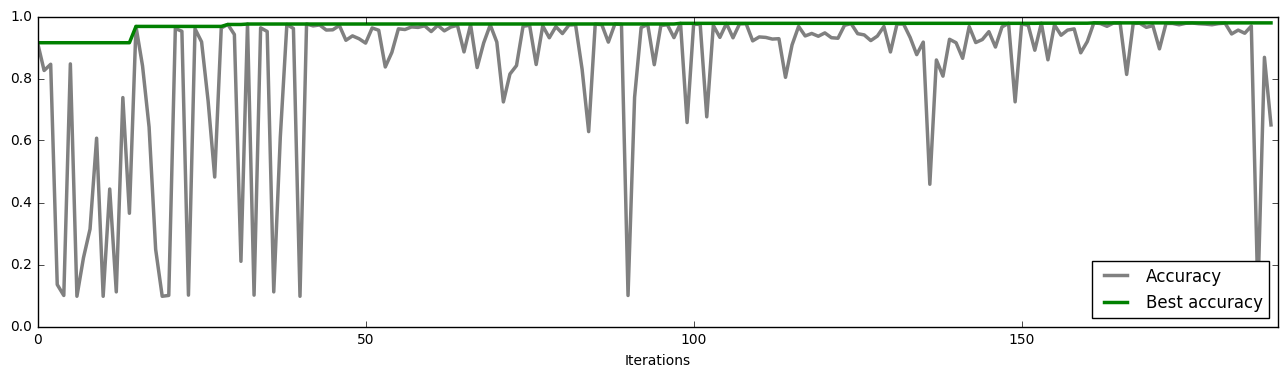

In [6]:
accBayes3 = processing.accuracy("results/hyperBayes3.json")
plots.summary(accBayes3, .9)
plots.accuracy(accBayes3)

We want to check if this solutions are close to one another, therefore, we apply MDS (nomralized with the possible research space)

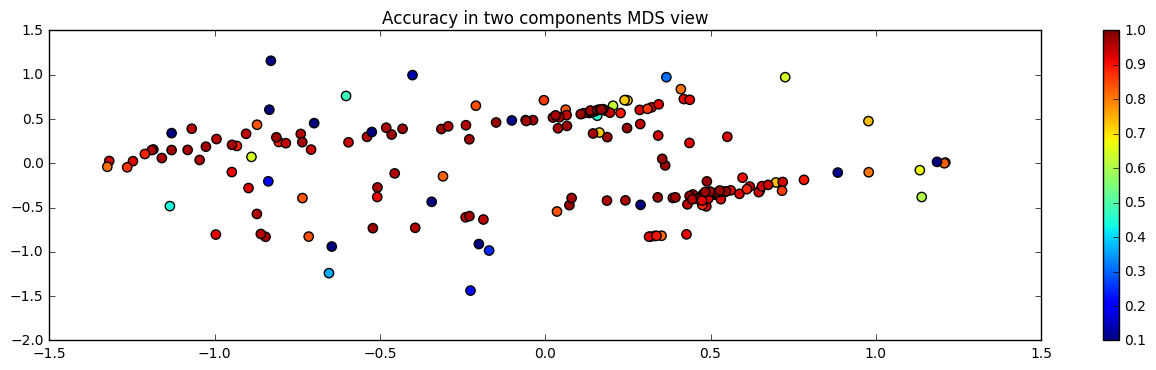

In [7]:
varBayes3 = []
for p in processing.params("results/hyperBayes3.json"):
    varBayes3.append([p["learning_rate"], p["decay"], p["moment"],
                    p["reg_l1"], p["reg_l2"], noeuds[0], noeuds[1]])
varBayes3 = np.array(varBayes3)

plots.mds_accuracy(varBayes3/ [.5,.1,.1,.1,.1,100, 100], accBayes3)

The algorithm is able to find good solutions throughout an important part of the solution space.

Next we tried to remove the limitation on the number of neurons per layer and enlarge it to 2 layers of 100 to 500 neurons. The density of solutions is well under the previous suite and the best solution a little worse.

Best accuracy: 0.9781 at iteration 208
Number of solutions better than 90%: 43.9%


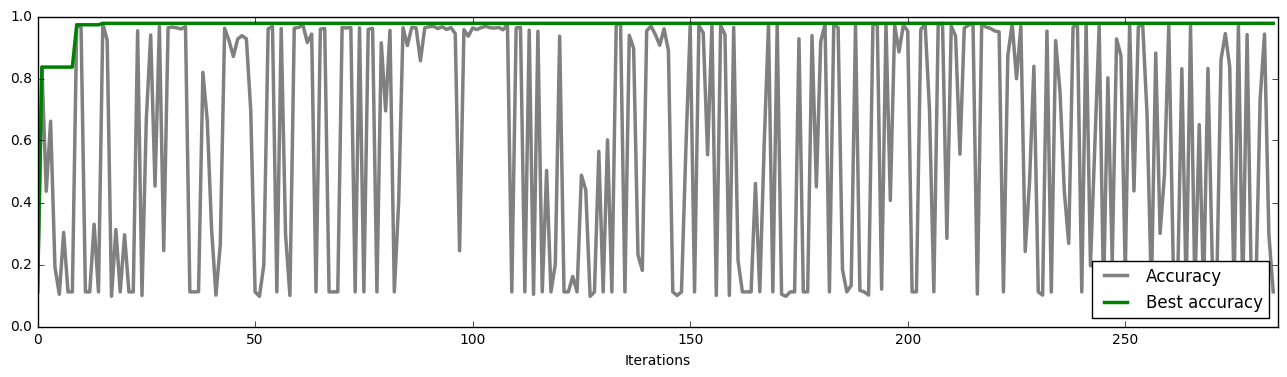

In [8]:
accBayes5 = processing.accuracy("results/hyperBayes5.json")
plots.summary(accBayes5, .9)
plots.accuracy(accBayes5)

## 6. Comparison & joint appoarch


The different models are difficult to compare because each one of them needed its own type of __adjustments__. Futhermore, every algorithm has a __stochatic__ aspect (often more important at the begining of the algorithm) that can change dramatically the performance. Making statistical sense would require running a huge amount of simulations.

However, there are several conclsions that we can draw:
* the random search is a bad approach for finding good solutions. Futhermore, the density of solutions seems to be so that running a random search for a larger number of iterations doesn't improve the quality of solution. Note that an inexperience individual trying to manually adjust parameters can be modeled as random and should instead look for different apporachs.
* MADS seems to be good for quickly refining a solution but not for exploring the whole search space.
* Bayesian optimization looks like it can explore a larger part of the search space as well as refining solutions.
* The neural network approach seems good to approximate the response surface near optimal solutions even overfitting may bias the solution. Once a good solution is found the algorithm tries to find other interesting areas to find a good solution.
* We didn't explore the behaviour of these algorithm on the very long run.

These algorithm makes possible to run a large ammount of tests to opimize the parameters. For this project we managed to test 100 to 500 configurations per algorithm, where less than 50 are computable manually.

### Working the models together
A first idea would be to run all algorithms, and multiple random initialization of the parameters, inpendently and in parallel. This could allow to get the best out of all algorithms.

One other idea would be that since Bayesian optimization recalculates the function density at every step with the previous observations, it could be easy to incorporate results from other algorithms into this search. The bayesian optimization. The other algorithms could then run again starting with the best solution predicted by bayesian optimization. The same idea can be applyed to the neural network algorithm.

Below, we show an example of our idea using only MADS as a side algorithm. To simplify, we will assume that one iteration on any algorithm takes exactly the same time.
<img src="img/together.png" style="width: 50%; float: right; padding: 10px;">
1. We start by running the bayesian optimization algorithm and the MADS algorithm for a fixed number of iteration (let's say 20)
2. The bayesian optimization predicts a best solution, this is used as an initial solution to run a new instance of the MADS algorithm (20 iterations)
3. The points from the first MADS are added to the bayesian optimization, which keeps running for anoter 20 iteration (getting up to 60 points)
4. We at the end of those 20 iteration we repeat the same exchange.

This scenario enable us to provide a lot of points to the bayesian optimization as well as using different algorithm to refine solutions.

We could add the NN designing NN as a side algorithm, as a replacement of bayesian optimization, or even as another master algorithm.

We did not have time to implement this apporach but we believe that, like __bagging__, this could lower the weakness of every algorithm.

## Reference and acknowledgements

Our experimentation would not be possible without the use of these great tools:
* <span id="1">[1]</span> __[Theano](https://github.com/Theano/Theano)__ Symbolic calculation library
* <span id="2">[2]</span> __[TensorFlow](https://www.tensorflow.org)__ Tensor manipulation
* <span id="3">[3]</span> __[Keras](https://github.com/fchollet/keras)__ Deep learning library
* <span id="4">[4]</span> __[NOMAD](https://www.gerad.ca/nomad/Project/Home.html)__ and __[OPAL](http://pythonoptimizers.github.io/opal/)__ Software for black box optimiaztion
* <span id="5">[5]</span> __[Spearmint](https://github.com/HIPS/Spearmint)__ Software to perform bayesian optimization

#### References
<span id="6">[6]</span> LeCun, Y., Cortes, C., & Burges, C. J. (1998). The MNIST database of handwritten digits.

<span id="7">[7]</span> Audet, C., & Dennis Jr, J. E. (2006). Mesh adaptive direct search algorithms for constrained optimization. SIAM Journal on optimization, 17(1), 188-217.

<span id="8">[8]</span> Audet, C., Dang, C. K., & Orban, D. (2011). Algorithmic parameter optimization of the DFO method with the OPAL framework. In Software Automatic Tuning (pp. 255-274). Springer New York.

<span id="9">[9]</span> Smithson, S. C., Yang, G., Gross, W. J., & Meyer, B. H. (2016). Neural networks designing neural networks: multi-objective hyper-parameter optimization. arXiv preprint arXiv:1611.02120.

<span id="10">[10]</span> Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical bayesian optimization of machine learning algorithms. In Advances in neural information processing systems (pp. 2951-2959).

<span id="11">[11]</span> Snoek, J., Rippel, O., Swersky, K., Kiros, R., Satish, N., Sundaram, N., ... & Adams, R. P. (2015, February). Scalable Bayesian Optimization Using Deep Neural Networks. In ICML (pp. 2171-2180).